# U-Net for Image Segmentation

## Overview
This notebook is the entry point for this project. 

## Structure
- **[Setup and Import Necessary Packages](#setup-and-import-necessary-packages)**: Install and import the libraries and packages needed for the project.
- **[Input File Directories, Load Data, and View a Sample of Data](#input-file-directories-load-data-and-view-a-sample-of-data)**: Load images and masks form the given directories, and view a sample of that data for verification.
- **[Configure and Preprocess Data](#configure-and-preprocess-data)**: Configure and prepare the data for the U-Net.
- **[Build and Train the U-Net Model](#build-and-train-the-u-net-model)**: Configure, build, and train the U-Net. 
- **[Model Evaluation](#model-evaluation)**: Evaluate the model and save the predictions if desired. 


## Usage
This notebook assumes that the helper functions (`utils.ipynb`), and the U-Net model functions (`unet.ipynb`) are imported correctly.

## Setup and Import Necessary Packages

In the following three code cells, we will set up our environment by installing the necessary packages and importing the required libraries, and then optionally setting our model for "production" or "testing". This setup includes custom utility functions, a U-Net model implementation, and setting the random seed.

### Step 1: Install Required Packages

First, we will use the `%pip` magic command to install the necessary packages from a `requirements.txt` file. This ensures that all dependencies are installed before we proceed with importing them.

If you don't have the `requirements.txt` file, you can find it [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).


In [ ]:
# Installing the necessary packages
%pip install -r requirements.txt

### Step 2: Import Necessary Packages

Next, we will import the necessary packages and libraries for our project. This includes:

- Standard libraries and packages
- Custom utility functions from `utils.py`
- U-Net model implementation and associated functions from `unet.py`

These custom files contain functions that will be used throughout this notebook.

In [1]:
# Necessary imports
import os
from pathlib import Path
import warnings
import import_ipynb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from utils import (
    load_images_and_masks,
    view_data,
    preprocess_images_and_masks,
    remap_mask_classes,
    custom_warnings,
)
from unet import (
    unet_model,
    test_unet,
    plot_losses,
    save_predicted_masks,
    iou_metric,
    dice_coeff,
)

# Optional line to suppress unnecessary tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras import callbacks, optimizers
import tensorflow as tf

# Force the warnings library to use the custom warnings format
warnings.formatwarning = custom_warnings

### Step 3: Setting to Production or Testing

Finally for setup we can set our model to be in testing mode (`PRODUCTION = False`) or production mode (`PRODUCTION = True`). 

In testing mode, this will keep the random seed the same across all the necessary libraries and packages, so that the code will have consistently reproducible results. 

In [3]:
# Force all seed values to be the same. This should only be done when testing.
PRODUCTION = False
seed_value = 42
if not PRODUCTION:
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)

## Input File Directories, Load Data, and View a Sample of Data

In the following three code cells, we will specify the file directories for images, masks, and model, and then load the data from these directories using a custom function. As a check that the data has been loaded correctly, we then view a small sample of the data.

### Step 4: Specify File Directories

First, we need to input the file directories where our images, masks, and models are stored. These directories will be used to load the data required for training and evaluation. These directories should all be relative file paths to the current working directory. 

In [4]:
# Set the necessary directories. These should be relative to the working directory
images_dir = "Datasets/Pala_Mesa_Roads_Rails/images" 
masks_dir = "Datasets/Pala_Mesa_Roads_Rails/labels"
model_dir = "models/"
model_name = "trained_UNet_Pala_Mesa.keras"
mode_path = Path(f"{model_dir}/{model_name}") 

### Step 5: Load the Images and Masks

The next code cell loads the images and masks using a custom function defined in `utils.ipynb`. You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). 

We have set the optional settings such as:
- `file_ext`: specifying the file extension type of our data
- `max_count`: the maximum number of images we would like to load in for our model
- `trim_names`: an additional feature that attempts to trim the filenames if they are of a format with characters and underscores preceding a large number of digits. More details can be found in the `utils.ipynb` under the `load_images_and_masks` function. 

In [5]:
# Load the images and masks
images, masks, missing_masks = load_images_and_masks(
    images_dir, masks_dir, file_ext="tif", max_count=1000, trim_names=True
)

### Step 6: View a Sample of Data

The next code cell lets us view a sample of our images and masks, to make sure that they have loaded as expected. Again this is a custom function that can be found in `utils.ipynb`. You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).

We have set the optional settings such as:
- `max_plots`: specifying the number of images (and masks) to plot
- `max_cols`: specifying the number of columns to use for display
- `randomize`: specifying to use a random subset of the loaded images (and their corresponding masks)
- `colors`: displaying the images and masks in color (as opposed to greyscale)

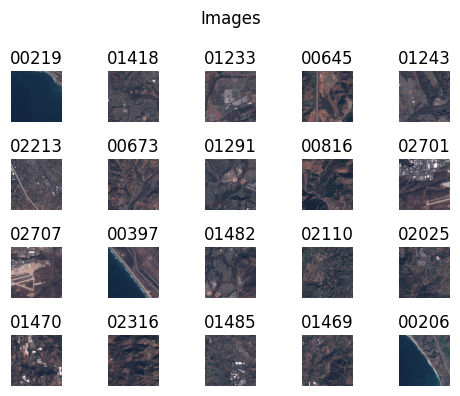

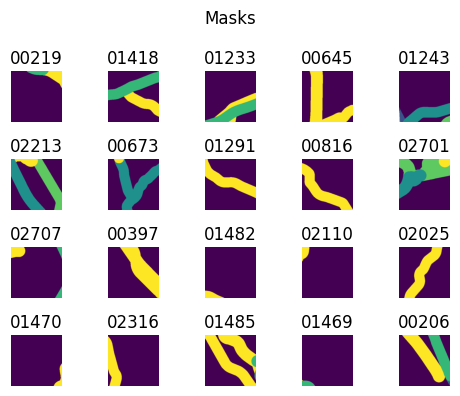

In [6]:
# View images and masks
view_data(
    images=images,
    masks=masks,
    max_plots=20,
    max_cols=5,
    randomize=True,
    colors=True,
)

## Configure and Preprocess Data

In the following three code cells, we will prepare our data for the U-Net mode. We will optionally remap classes, preprocess the data, and split it into training, validation, and test sets.

### Step 7: Optionally Remap the Mask Classes

You can optionally remap the mask classes down to a subset of the mask classes. This is done using a custom function that can be found in `utils.ipynb`. You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). 

An important feature of the `remap_mask_classes` function: There are instances where, if it finds some discrepancies in the inputs, it will ask the user what they would like to do. Please follow the prompts accordingly.

We have set `REMAP_CLASSES = False`. If we chose to set it to `True`, then the `class_mapping` would map the old class index values to the new class index values. In the example, this maps old values `0,1,2,3` to new values `0,1`. We have also implemented the custom `view_data` function shown previously in [Step 6](#step-6-view-a-sample-of-data). Notice that in this case, only the masks were provided, since the images will remain unchanged. Please also note that the function outputs not only the new masks but the `num_classes` which can be used as an input in [Step 8](#step-8-preprocess-the-data)

In [8]:
# Optional remapping of classes
REMAP_CLASSES = False
class_mapping = {0: 0, 1: 1, 2: 1, 3: 1} # keys are old classes, values are the new classes
if REMAP_CLASSES:
    masks, num_classes = remap_mask_classes(masks, class_mapping)
    view_data(masks=masks, max_plots=20, max_cols=5, randomize=False, colors=True)

### Step 8: Preprocess the Data

Next, we need to ensure that the data is in the correct format for the U-Net. This is done using the custom function `preprocess_images_and_masks` that can be found in `utils.ipynb`. You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).
We have set the optional settings such as:
- `num_classes`: the number of classes we believe to be in our masks. It is alright if the number of classes is incorrect as the `preprocess_images_and_masks` is designed to handle that. Please note that if you do remap the mask classes using the `remap_mask_classes` function in the previous step, you should use the output `num_classes` as your input here. 
- `threshold`: setting the value to use in the case of a binary mask (a mask with only background and foreground classes). It already has a default of 0.5, if it isn't set. 

An important feature of the `preprocess_images_and_masks` function: There are instances where, if it finds some discrepancies in the inputs, it will ask the user what they would like to do. Please follow the prompts accordingly.

The `preprocess_images_and_masks` will output some basic information about the images, masks, and the number of classes. This is a convenent checkpoint to verify that the data is formatted as expected. For example the number of images and masks should be the same, the height and width of the images should be the same, and the type of the data should be in a format usable by a Tensorflow model like float32. You can use the number of classes later in [Step 15](#step-15-test-the-trained-model) to label the classes (for display purposes only).

In general the number of classes should match the the 4th dimension in the masks shape. However there are a handful of exceptions. In the case where there are initially 2 masks classes, the data will be mapped to a binary case (foreground and background) for faster data processing, and you will be notified in a print out. While we can still think of this as two classes, the U-Net understands it as a single class. Similarly if the data is already in binary format it will only be one class. When there is only one class, the 4th dimension is not needed. All of this is handled in the `preprocess_images_and_masks` function, and is accounted for in later functions as well. 

In [9]:
# Preprocess the data for the U-Net
# Assign default values to the number of classes
num_classes = 4
preprocessed_images, preprocessed_masks, threshold, image_names, num_classes = (
    preprocess_images_and_masks(
        images, masks, num_classes=num_classes, threshold=0.5
    )
)

Preprocessed data information:
Number of images: 1000.
Shape of images dataset: (1000, 256, 256, 3).
Images type: float32.
Number of masks: 1000.
Shape of masks dataset: (1000, 256, 256, 5).
Masks type: float32.
Number of classes: 5.


### Step 9: Split the Data

The final step of preparing the data for the U-Net, is to split the data into training, validation, and test sets. 

First we split out 80% of the data for training, by setting the `test_size`variable to `0.2`. We also set the `random_state` to our `seed_value` from [Step 3](#step-3-setting-to-production-or-testing). If desired, this variable can be removed from the input. Note that the `train_test_split` function is a scikit learn function, and the details can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We then apply the same function to the remaining 20% of the data and split it evenly into validation, and testing data sets. 

In both splits we include a list with the names of the images, so that we can keep the original image names, and use them later on in [Step 15](#step-15-test-the-trained-model). This is necessary, as `train_test_split` randomizes the order of the images. 

This step is very important as it ensures that our model will have test data that it has never seen before, which is important for a true test of the model's ability to predict the mask classes based on the images. 

In [10]:
# Splitting the data into training, validation, and test
# Split out the training data
(
    images_train,
    images_test_and_val,
    masks_train,
    masks_test_and_val,
    names_train,
    names_test_and_val,
) = train_test_split(
    preprocessed_images,
    preprocessed_masks,
    image_names,
    test_size=0.2,
    random_state=seed_value,
)

# Split the remaining data into validation and test
(
    images_validation,
    images_test,
    masks_validation,
    masks_test,
    names_validation,
    names_test,
) = train_test_split(
    preprocessed_images,
    preprocessed_masks,
    image_names,
    test_size=0.5,
    random_state=seed_value,
)


## Build and Train the U-Net Model

In the following three code cells, we will configure and build the U-Net model, assign training parameters, and train the model.

### Step 10: Configure and Build the U-Net Model

We first configure our model parameters. 

The first parameter is the optimizer, which is the optimization function used to update the model's weights and biases to minimize the loss function. In short it determines how the model learns. In our example we have chosen to use the `Adam` optimizer with a specific `learning_rate`. Note that, as with most machine learning libraries the function is already built into the library, in this case Tensorflow. Details can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

THe next parameter we assign are the metrics. The default metric is `["accuracy"]` which is a simple metric that shows how often the prediction masks in training, match the labels. Instead we have chosen to use two custom metrics defined in `unet.ipynb`:
- `iou_metric`: Intersection Over Union (IOU) measures the overlap between the predicted mask classes, and the true mask classes.
- `dice_coeff`: Dice ceofficient also measures the overlap between the predicted mask classes and the true mask classes, but it weights true positives by a factor of 2. 

Both of the above metrics are custom defined functions whose details can be found in `unet.ipynb` or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).It is important to note, that because these are custom metrics, rather than Tensorflows built in metrics like `"accuracy"`, we must provide a dictionary of those custom objects, if we wish to save and load our model for future use, or after training. We do that with `custom_objects`, and you can see where this is relevant in [Step 14](#step-14-optionally-load-a-saved-model) 

Next we can call our custom `unet_model` function defined in `unet.ipynb`. This is a 'functional' implementation of a Tensorflow `Model` class, which means that we define a function that creates the `Model` class object defined by Tensorflow, which in turn means we have access to Tensorflow's `Model` class properties like `.summary()`. You can find more details on how to construct a "functional" model or how to subclass the `Model` class [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In our example the images are of shape 256 x 256, and they are 3 channel RGB images. 
The `num_classes` corresponds to the `num_classes` output by `preprocess_images_and_masks` in [Step 8](#step-8-preprocess-the-data).
We have set the optional settings such as:
- `num_blocks`: setting the depth of the U-Net to `4`, which means that there are 4 encoder blocks, and their corresponding 4 decoder blocks. 

Finally `model.summary()` prints a summary of the U-Net model structure, including each layer in each block, the layer type, the output shape of each layer, the number of parameters in each layer, and the layer's connection to other layers. Please note, that the output shape always starts with `None`. This is the batch size of the data, and this is not fixed nor set in our model. 

More details on the U-Net model and it's structure can be found in `unet.ipynb` or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024)

In [11]:
# Build the U-Net
# Specify the details of the optimizer
optimizer = optimizers.Adam(learning_rate=1e-4) # "adam", 

# Create the model
# NOTE: We have chosen to use some custom metrics iou_metric and dice_coeff. The default value is ["accuracy"].
metrics = [iou_metric, dice_coeff]
custom_objects = {"iou_metric": iou_metric, "dice_coeff": dice_coeff}
model = unet_model(
    input_shape=(256, 256, 3),
    num_classes=num_classes,
    num_blocks=4,
    optimizer=optimizer,
    metrics=metrics, # ["accuracy"]
)
# Get a print out of the model structure.
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,379,205 (119.70 MB)

 Trainable params: 31,379,205 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

### Step 11: Configure Training Parameters

Next we configure the training parameters we'd like to use for our model. 

We first set three model callbacks, which are built in parameters that we can use from Tensorflow. We implement a learning rate scheduler, using `ReduceLROnPlateau` which reduces the learning rate of our model by a factor of 0.5 when the validation loss (`"val_loss"`) plateaus after 5 epochs. We similarly set the model to stop training early using `EarlyStopping`, when the validation loss stops improving after 10 epochs, and we set it ot return the best weights when it does stop early. We also also use `ModelCheckpoint` to set the model to save the best weights based on the performance of the validation loss, at every epoch (by default). The details of these three callbacks, and others can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/).

We also set: 
- `epochs`: the number of times the entire data set is passed throuhg the model. More epochs means that the model is able to better train to the data it is given, but an increase in epochs also risks the model overfitting to the training dataset. 
- `batch_size`: the number of data samples processed before weights are updated; the 'batching' of the data. A smaller batch size updates the model more frequently and require less memory, but it is also noisier during training. 
- `model_verbosity`: The amount and type of information displayed during training, and the frequency with which the information is displayed. Setting verbsoity to `1` gives us the progress over each epoch, including approximate completion time of training for that epoch, and a detailed printout, depending on the verbosity of our callbacks and metrics, of the training parameters. 

In [12]:
# Assign specific training parameters
# Learning rate scheduler to adjust the learning rate if the validation loss is not improving.
learning_rate_scheduler = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
# Stop the model early, and keep the best results, if the validation loss is not improving.
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
# Save the best model as determined by the validation loss. The default save frequency is every epoch.
checkpoint = callbacks.ModelCheckpoint(
    mode_path, save_best_only=True, monitor="val_loss"
)

# Gather the model callbacks into a single variable
model_callbacks = [learning_rate_scheduler, early_stop, checkpoint]

# Assign the number of epochs. 
epochs = 25
batch_size = 8
model_verbosity = 1

### Step 12: Train the Model

We are finally ready to train our model! We pass through the `model` from [Step 10](#step-10-configure-and-build-the-u-net-model), our parameters from [Step 11](#step-11-configure-training-parameters), and our training and validation data from [Step 9](#step-9-split-the-data). Again please note that we are able to call `model.fit` because our model is a Tensorflow `Model` class and has the property `.fit`. You can find the full details on the Tensorflow `Model` class [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [13]:
# Train the model
model_fit = model.fit(
    images_train,
    masks_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_validation, masks_validation),
    callbacks=model_callbacks,
    verbose=model_verbosity,
)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 842s 8s/step - dice_coeff: 0.4612 - iou_metric: 0.3131 - loss: 1.1120 - val_dice_coeff: 0.6184 - val_iou_metric: 0.4496 - val_loss: 0.8134 - learning_rate: 1.0000e-04
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 861s 9s/step - dice_coeff: 0.6119 - iou_metric: 0.4442 - loss: 0.8086 - val_dice_coeff: 0.6095 - val_iou_metric: 0.4408 - val_loss: 0.7810 - learning_rate: 1.0000e-04
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 857s 9s/step - dice_coeff: 0.6171 - iou_metric: 0.4500 - loss: 0.8011 - val_dice_coeff: 0.6011 - val_iou_metric: 0.4324 - val_loss: 0.7717 - learning_rate: 1.0000e-04
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 850s 9s/step - dice_coeff: 0.6383 - iou_metric: 0.4718 - loss: 0.7587 - val_dice_coeff: 0.6024 - val_iou_metric: 0.4333 - val_loss: 0.7445 - learning_rate: 1.0000e-04
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 839s 8s/step - dice_coeff: 0.6506 - iou_metric: 0.4843 - loss: 0.7285 - val_dice_coeff: 0.6029 - val_iou_metric: 0.4340 - val_loss: 

## Model Evaluation

In this final section we have four code cells for model evaluation: we will plot the training and validation losses, optionally load a saved model, test the trained model, and optionally save the predicted masks as images.

### Step 13: Plot Training Losses

In this step we call a custom function `plot_losses`, to plot the training and validation losses of the model over the epochs. The details of this function can be found in `unet.ipynb` and [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). From this plto we can determine if the model has been fully trained (has the loss begun to plateau) and whether the model is being overfit to the training data (the validation loss gets larger while the training loss plateaus or decreases).


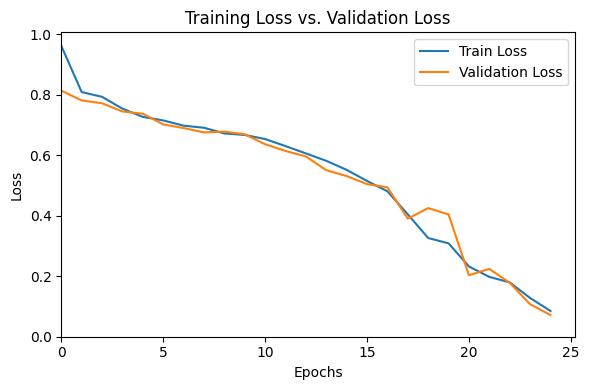

In [14]:
# View model losses
plot_losses(model_fit)

### Step 14: Optionally Load a Saved Model

In this step, we can optionally load a previously saved model. This is useful if we have a model that we would like to train on a new set of data, if our training was previously interrupted, or if we'd like to test a model on a new data set. Recall from [Step 10](#step-10-configure-and-build-the-u-net-model) we used custom metrics and saved them to a dictionary `custom_objects`. Because we used custom metrics, we must include that dictionary when loading our model. Tensorflow does not save custom objects (in our case only custom metrics, but you can also define custom callbacks, custom optimizers, etc.) when saving the model, but becasue they are referenced in the model, they must be defined when loading the model. 

In [15]:
# Optional loading of a model
# NOTE: If you have use custom metrics, you must explicitly load them back in with the model. 
LOAD_MODEL = False
if LOAD_MODEL:
    model = tf.keras.models.load_model(
        mode_path, custom_objects=custom_objects
    )

### Step 15: Test the Trained Model

In this step we can test how our model performs on our test data set generated in [Step 9](#step-9-split-the-data). 
We first ensure that our model is fixed, so that it will not update by setting `model.trainable = False`.
We can use the number of classes printed out in [Step 8](#step-8-preprocess-the-data), to assign `class_labels` if we'd like, to use in the figures of the masks. Similarly we can specify the color map to use when displaying the masks. The color maps come from the `matplotlib` library and can be found [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

We then call the custom function `test_unet`. This is defined in `unet.ipynb` and additional details can be found there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). We feed in the model, the test images and masks, and the number of classes. 
We have set the optional settings such as:
- `threshold`: The threshold to use on binary data when separating it into foreground and background. The default is 0.5, and it is an output of the `preprocess_images_and_masks` in [Step 8](#step-8-preprocess-the-data), as a precaution, since in the preprocessing, as previously discussed, we may convert multi-class masks to binary masks where appropriate. 
- `image_names`: The names of the images to display. We set this value in [Step 9](#step-9-split-the-data).
- `display_count`: The number of predicted masks to display. Because the figure displays the image, the true mask, and the predicted mask, you should keep this value relatively small to avoid clutter. 
- `class_labels`: The labels for the classes. Note that if this is incorrect, the values will be overriden with just the class index.
- `class_color_map`: the color map that we specified using the `matplotlib` library's color maps. 

The `test_unet` function will output Precision, Recall, and F1 Scores for each class, or single values in the binary mask classes case. These three metrics are defined in  `unet.ipynb` but are included here for clarity as well:
- Precision: Calculates the precision, which is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of the accuracy of the positive predictions.
    - Precision = true_positives / (true_positives + false_positives)
- Recall: Calculates the recall, also known as sensitivity or true positive rate, which is the ratio of correctly predicted positive observations to all the actual positives. It is a measure of how well the model can capture positive instances.
    - Recall = true_positives / (true_positives + false_negatives)
- F1 Score: Calculates the F1 score, which is the weighted average of precision and recall. It considers both false positives and false negatives and is useful when you need a balance between precision and recall.
    - F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step
Number of class labels (4) does not match the number of classes (5). Labels will be changed to class index numbers.
Metrics based on test data:

Class 0 Individual Metrics:
Precision: 0.9713844516320829
Recall: 0.9882610383673625
F1 Score: 0.979750073901484

Class 1 Individual Metrics:
Precision: 0.9404019493681804
Recall: 0.8437279927495918
F1 Score: 0.889445808163946

Class 2 Individual Metrics:
Precision: 0.9264425526240323
Recall: 0.8745839131202651
F1 Score: 0.8997666257171921

Class 3 Individual Metrics:
Precision: 0.9367491783526932
Recall: 0.8958469576762879
F1 Score: 0.915841614019153

Class 4 Individual Metrics:
Precision: 0.9070020905679522
Recall: 0.9078184069017564
F1 Score: 0.9074100651430451



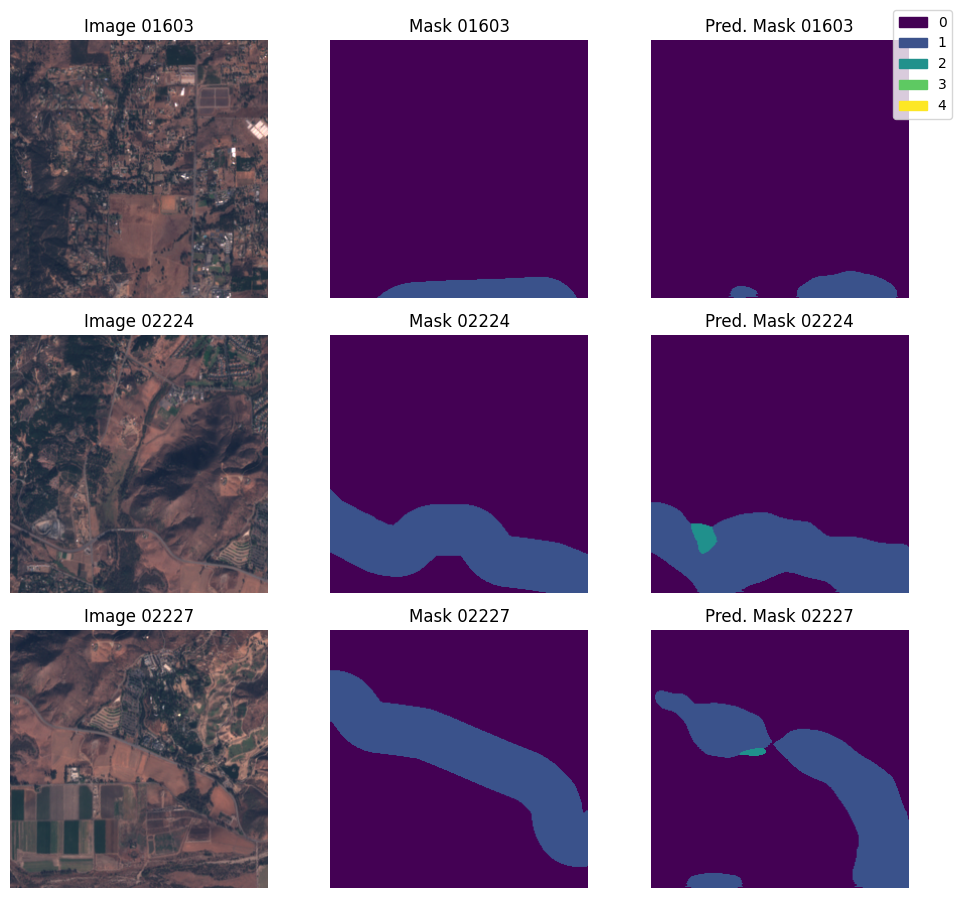

In [17]:
# Ensure that the model won't change now that it has finished training
model.trainable = False
# Test the model
class_labels = {0: "Background", 1: "Low Risk", 2: "Medium Risk", 3: "High Risk"}
class_color_map = "viridis"
predicted_masks = test_unet(
    model,
    images_test,
    masks_test,
    num_classes,
    threshold=threshold,
    image_names=names_test,
    display_count=3,
    class_labels=class_labels,
    class_color_map=class_color_map,
)

### Step 16: Optionally Save the Predicted Masks

In this step, we have included the option to save the predicted masks as images in the users format of choice, though preferably `tif` or `png`. 

The `save_predicted_masks` is a custom function whose details can be found in `unet.ipynb` or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).

We have set the optional settings such as:
- `mask_names`: the names of the test masks which we generated in [Step 9](#step-9-split-the-data).
- `file_ext`: the file extension (or format) we would like to save the predicted masks in. The default is `tif`

In [18]:
# Save the predicted masks
SAVE_PREDICTED_MASKS = True
predicted_masks_dir = Path(f"{model_dir}/predicted_masks/")
if SAVE_PREDICTED_MASKS:
    save_predicted_masks(
        predicted_masks, predicted_masks_dir, mask_names=names_test, file_ext="tif"
    )